In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import urllib.request
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

import subprocess

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
try:
    from einops import rearrange
except ImportError:
#     %pip install einops
    from einops import rearrange


In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    # Download the image using wget
    subprocess.run(['wget', 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg', '-O', 'dog.jpg'])

torch.Size([3, 1365, 2048])


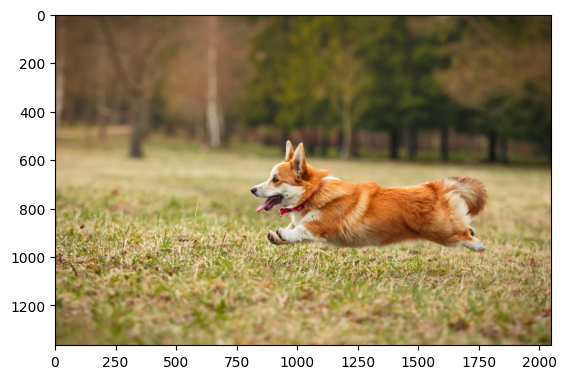

In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [ ]:
#Scaling the Original image
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled).float().to(device)

print("img_scaled.shape", img_scaled.shape)
print("img_scaled", img_scaled)

img_scaled.shape torch.Size([3, 1365, 2048])
img_scaled tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
  

OriginalImg.shape torch.Size([3, 400, 400])


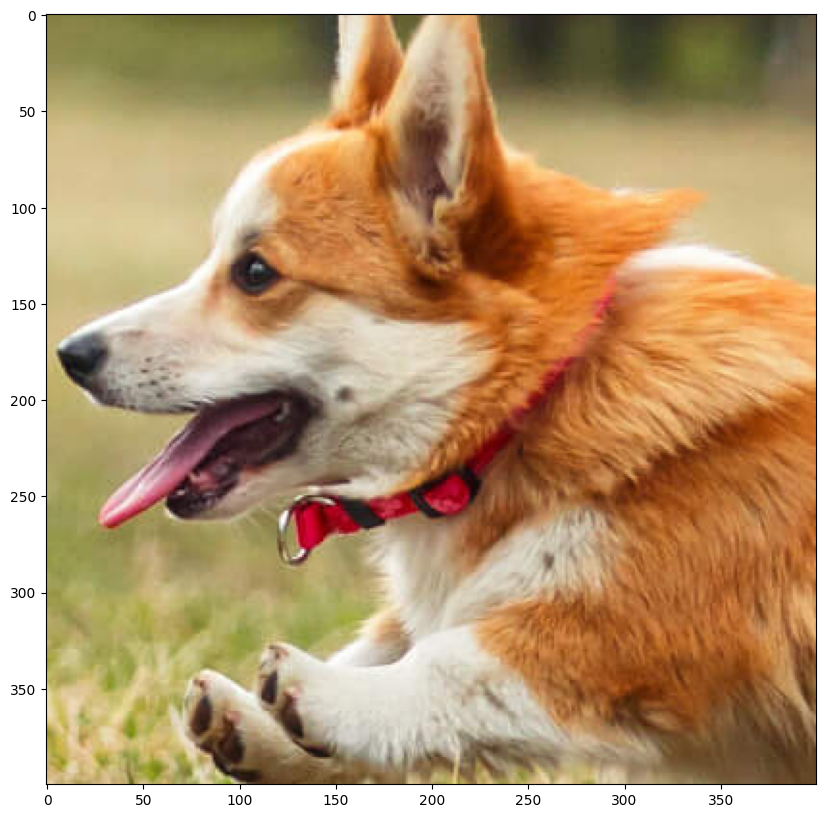

In [ ]:
# Cropping the image to 400X400
OriginalImg = torchvision.transforms.functional.crop(img_scaled.cpu(), 550, 800, 400, 400)
print("OriginalImg.shape", OriginalImg.shape)
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())


low_res_img.shape torch.Size([3, 200, 200])


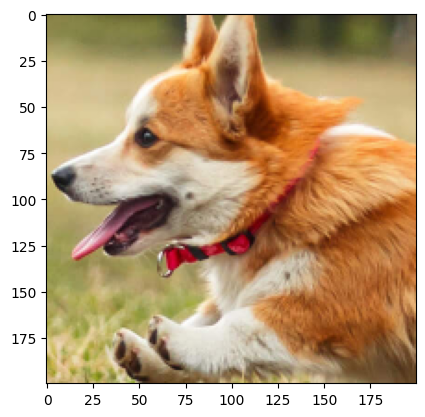

In [ ]:
# Cropping the image to 200X200 for training using convolution
scale = 2
num_channels, height, width = OriginalImg.shape
height //= scale
width //= scale
low_res_img = torch.zeros((num_channels,height,width)).to(device)
for i in range(height):
  for j in range(width):
    low_res_img[:, i, j] = torch.mean(OriginalImg[:, 2*i:2*i+2, 2*j:2*j+2], dim=(1, 2))
print("low_res_img.shape", low_res_img.shape)
plt.imshow(rearrange(low_res_img, 'c h w -> h w c').cpu().numpy())


In [ ]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y


In [ ]:
# Creating the coordinate map of low resolution image (200X200)
dog_X, dog_Y = create_coordinate_map(low_res_img)
print("dog_X.shape: ", dog_X.shape, "\ndog_Y.shape: ", dog_Y.shape)
print("dog_X:", dog_X)
print("dog_Y:", dog_Y)


dog_X.shape:  torch.Size([40000, 2]) 
dog_Y.shape:  torch.Size([40000, 3])
dog_X: tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]])
dog_Y: tensor([[0.5235, 0.5000, 0.2725],
        [0.5235, 0.5000, 0.2725],
        [0.5235, 0.5000, 0.2725],
        ...,
        [0.3961, 0.2824, 0.1569],
        [0.3971, 0.2833, 0.1578],
        [0.3990, 0.2853, 0.1598]])


In [ ]:
# Scaling the low resolution coordinate mapped image

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

print("dog_X_scaled:", dog_X_scaled)
print("dog_X_scaled.shape:", dog_X_scaled.shape)


dog_X_scaled: tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]])
dog_X_scaled.shape: torch.Size([40000, 2])


In [ ]:
# Creating 10000 features for RFF Super resolution for training the 200X200 scaled image
num_features = 10000
sigma = 0.03
rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
X_rff = torch.tensor(rff.fit_transform(dog_X_scaled.cpu().numpy())).float().to(device)
print("X_rff.shape:", X_rff.shape)
print("X_rff:", X_rff)


X_rff.shape: torch.Size([40000, 10000])
X_rff: tensor([[ 1.4030e-02, -7.5783e-03, -1.3837e-02,  ..., -1.3946e-02,
          1.1493e-02, -1.3086e-02],
        [ 1.4070e-02, -6.3188e-03, -1.4142e-02,  ..., -1.4131e-02,
          1.4126e-02, -1.3975e-02],
        [ 1.3385e-02, -4.9931e-03, -1.3882e-02,  ..., -1.4089e-02,
          1.2231e-02, -1.0848e-02],
        ...,
        [ 7.3025e-03, -7.2673e-03,  9.6413e-03,  ...,  1.3780e-02,
          7.6068e-03, -1.0545e-02],
        [ 9.8438e-03, -8.4687e-03,  1.1506e-02,  ...,  1.4072e-02,
         -8.6598e-05, -4.1631e-03],
        [ 1.1879e-02, -9.5816e-03,  1.2911e-02,  ...,  1.4137e-02,
         -7.7522e-03,  3.4149e-03]])


In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
# Training the model for 10000 features on the 200X200 scaled image
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
net
dog_Y = dog_Y.to(device)
train(net, 0.01, X_rff, dog_Y, 100)

# Deleting unnecessary data
import gc
del X_rff, dog_X, dog_Y, dog_X_scaled
gc.collect()


```Epoch 0 loss: 0.346784```

In [ ]:
# Creating new coordinate map from the learned features
dog_X_, dog_Y_ = create_coordinate_map(low_res_img, scale = 2)

print("dog_X_.shape: ", dog_X_.shape, "dog_Y_.shape: ", dog_Y_.shape)
print("dog_X_: ", dog_X_)
print("dog_Y_: ", dog_Y_)

```
dog_X_.shape:  torch.Size([160000, 2])
dog_Y_.shape:  torch.Size([40000, 3])
dog_X_:  tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]])
dog_Y_:  tensor([[0.5235, 0.5000, 0.2725],
        [0.5235, 0.5000, 0.2725],
        [0.5235, 0.5000, 0.2725],
        ...,
        [0.3961, 0.2824, 0.1569],
        [0.3971, 0.2833, 0.1578],
        [0.3990, 0.2853, 0.1598]])
```

In [ ]:
# Again Scaling the coordinate mapped learned input between (-1,1)

# MinMaxScaler from -1 to 1
scaler_X_ = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X_.cpu())

# Scale the X coordinates
dog_X_scaled_ = scaler_X_.transform(dog_X_.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled_ = torch.tensor(dog_X_scaled_).to(device)

# Set to dtype float32
dog_X_scaled_ = dog_X_scaled_.float()

print("dog_X_scaled_", dog_X_scaled_)


```
dog_X_scaled_ tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]])
```

In [ ]:
# Utilising the rff transformation for generating the 400X400 from 200X200 image
X_rff = rff.transform(dog_X_scaled_.cpu().numpy())

X_rff = torch.tensor(X_rff).float().to(device)
print("dog_X_scaled_.shape", dog_X_scaled_.shape)

print("X_rff.shape", X_rff.shape)
print("X_rff", X_rff)


```
dog_X_scaled_.shape torch.Size([160000, 2])
X_rff.shape torch.Size([160000, 10000])
X_rff tensor([[ 0.0140, -0.0076, -0.0138,  ..., -0.0139,  0.0115, -0.0131],
        [ 0.0141, -0.0070, -0.0141,  ..., -0.0141,  0.0134, -0.0140],
        [ 0.0141, -0.0063, -0.0141,  ..., -0.0141,  0.0141, -0.0140],
        ...,
        [ 0.0098, -0.0085,  0.0115,  ...,  0.0141, -0.0001, -0.0041],
        [ 0.0109, -0.0090,  0.0123,  ...,  0.0141, -0.0041, -0.0004],
        [ 0.0119, -0.0096,  0.0129,  ...,  0.0141, -0.0078,  0.0034]])
```

In [ ]:
def plot_Original_vs_Predicted_Img(OriginalImg, X_rff_pred, net, return_Output = 0, save_path="comparison.png"):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_pred: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    with torch.no_grad():
        outputs = net(X_rff_pred)
        print("outputs.shape: ", outputs.shape)  # Check if this shape matches (num_samples, height * width, num_channels)

        pred_img = outputs.to(device)
        print("predicted_img.shape: ", pred_img.shape)
        pred_img = rearrange(pred_img, '(h w) c -> c h w', h=height, w=width)
        print("predicted_img.shape: ", pred_img.shape)

    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Image ({height}x{width})')
    ax1.imshow(rearrange(pred_img,'c h w -> h w c').cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    if(return_Output == 1):
        return pred_img

In [ ]:
# Predicting the 400X400 from the 200X200 image using RFF features (=10000)
# X_rff as input for predicting the super-resolution image

predicted = plot_Original_vs_Predicted_Img(OriginalImg, X_rff, net, return_Output=1, save_path="comparison_image.png")

```
outputs.shape:  torch.Size([160000, 3])
predicted_img.shape: torch.Size([160000, 3])
predicted_img.shape: torch.Size([3, 400, 400])
```

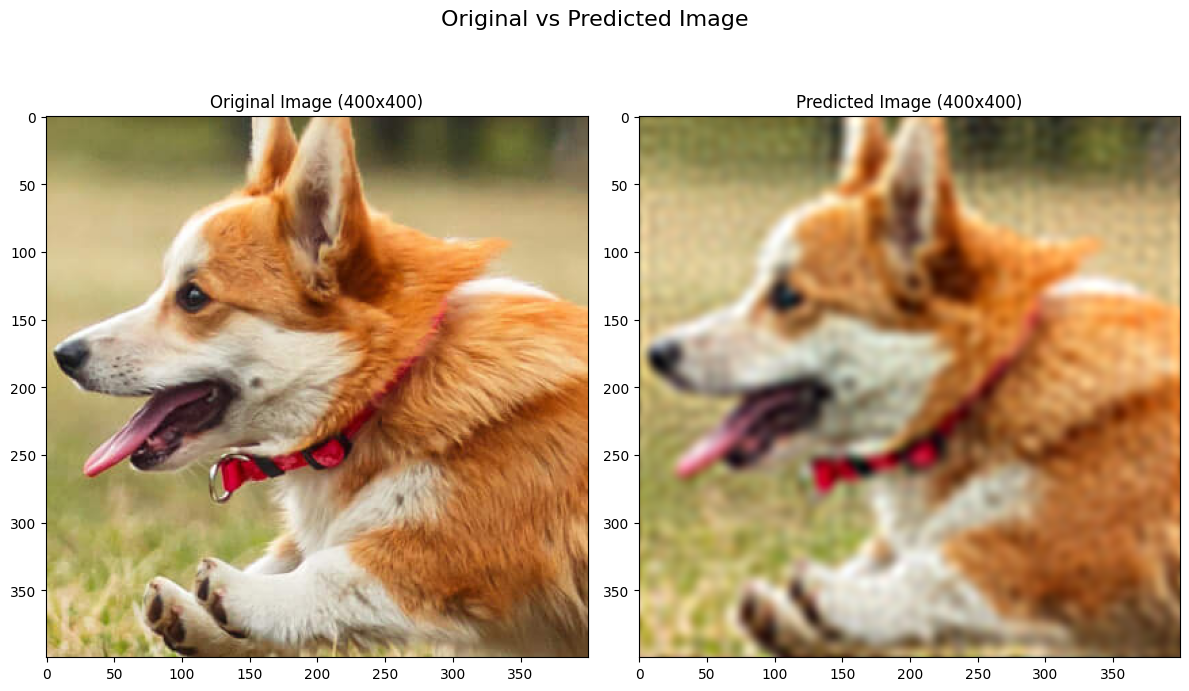

In [ ]:
def calRMSE_and_PSNR(img1, img2):
    """
    img1, img2: torch.Tensor of shape (num_channels, height, width) normalized between [0, 1]
    return: tuple of float and float
    """
    # Ensure both images are on the same device
    img1 = img1.to(device)
    img2 = img2.to(device)

    # Calculate RMSE
    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))

    # Calculate PSNR
    psnr = 20 * torch.log10(1.0 / rmse)

    return rmse.item(), psnr.item()

In [ ]:
OriginalImg = OriginalImg.to(device)
predicted = predicted.to(device)

In [ ]:
print("shape of Original: ", OriginalImg.shape)
print("shape of predicted: ", predicted.shape)

```
shape of Original:  torch.Size([3, 400, 400])
shape of predicted:  torch.Size([3, 400, 400])
```

In [ ]:
# Calculating rmse and psnr values for predicted image with respect to the original image

rmse, psnr = calRMSE_and_PSNR(OriginalImg, Y)
print("RMSE: ", rmse, "\nPSNR: ", psnr)

```
RMSE:  0.048074871301651
PSNR:  26.361637115478516
```